# Data cleaning example

Now we've gone over how to visualize and clean data, let's take a look at how we would use this in real life.

Our goal is to take a data set from an API, and use it for some analysis.  However, our API is a little flakey and the data sometimes isn't great, so we'll need to figure out what we need to correct

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import math

%matplotlib inline

In [2]:
def get_data(token):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-12-01').timestamp()))
        }
    )
    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ['BTC', 'ETH', 'USDT', 'SOL', 'ADA', 'XRP', 'DOT', 'AVAX']

In [4]:
dfs = [
    (lambda x: x.assign(chain=np.where(x.token.isin(['ETH', 'AAVE', 'COMP']), np.full(x.shape[0], 'ETH'), x.token)))(get_data(token)) 
    for token in tokens
]

df = pd.concat(get_data(token) for token in tokens)
df['chain'] = np.where(df.token.isin(['ETH', 'AAVE', 'COMP']), np.full(df.shape[0], 'ETH'), df.token)
df.set_index('ts', inplace=True)

In [5]:
# do some chaos monkeying
df['close'] = df['close'].mask(np.random.random(df.shape[0]) < .05, other=np.nan)
df['close'] = df['close'].mask(np.random.random(df.shape[0]) < .01, other=df['close'] * 100)
df['token'] = df['token'].mask(np.random.random(df.shape[0]) < .05, other='<a>' + df['token'] + '</a>')
df = df.append(df.sample(frac=0.1)).sample(frac=1)

First, let's check our time series

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3442 entries, 2021-12-11 17:00:00 to 2021-12-05 08:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       3442 non-null   float64
 1   high       3442 non-null   float64
 2   low        3442 non-null   float64
 3   close      3280 non-null   float64
 4   volume     3442 non-null   float64
 5   volumeUSD  3442 non-null   float64
 6   token      3442 non-null   object 
 7   chain      3442 non-null   object 
dtypes: float64(6), object(2)
memory usage: 242.0+ KB


we can see that we have 2264, total entries, but close has a bunch of nulls

In [7]:
df['token'].value_counts()

DOT            481
AVAX           468
ETH            467
BTC            467
USDT           466
SOL            463
ADA            460
<a>AVAX</a>     29
<a>ETH</a>      27
<a>SOL</a>      26
<a>ADA</a>      26
<a>USDT</a>     25
<a>BTC</a>      21
<a>DOT</a>      16
Name: token, dtype: int64

we also have some badly formatted token names (maybe we pulled from html)

In [8]:
df.duplicated().sum()

313

we also have some duplicated rows it looks like

<AxesSubplot:xlabel='ts'>

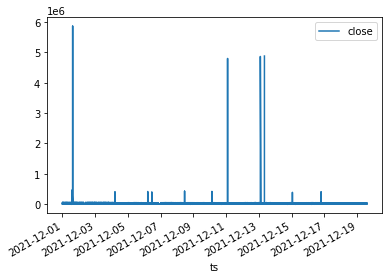

In [9]:
df[['token', 'close']].plot()

this plot doens't make sense because we have a long table.  Let's plot by token

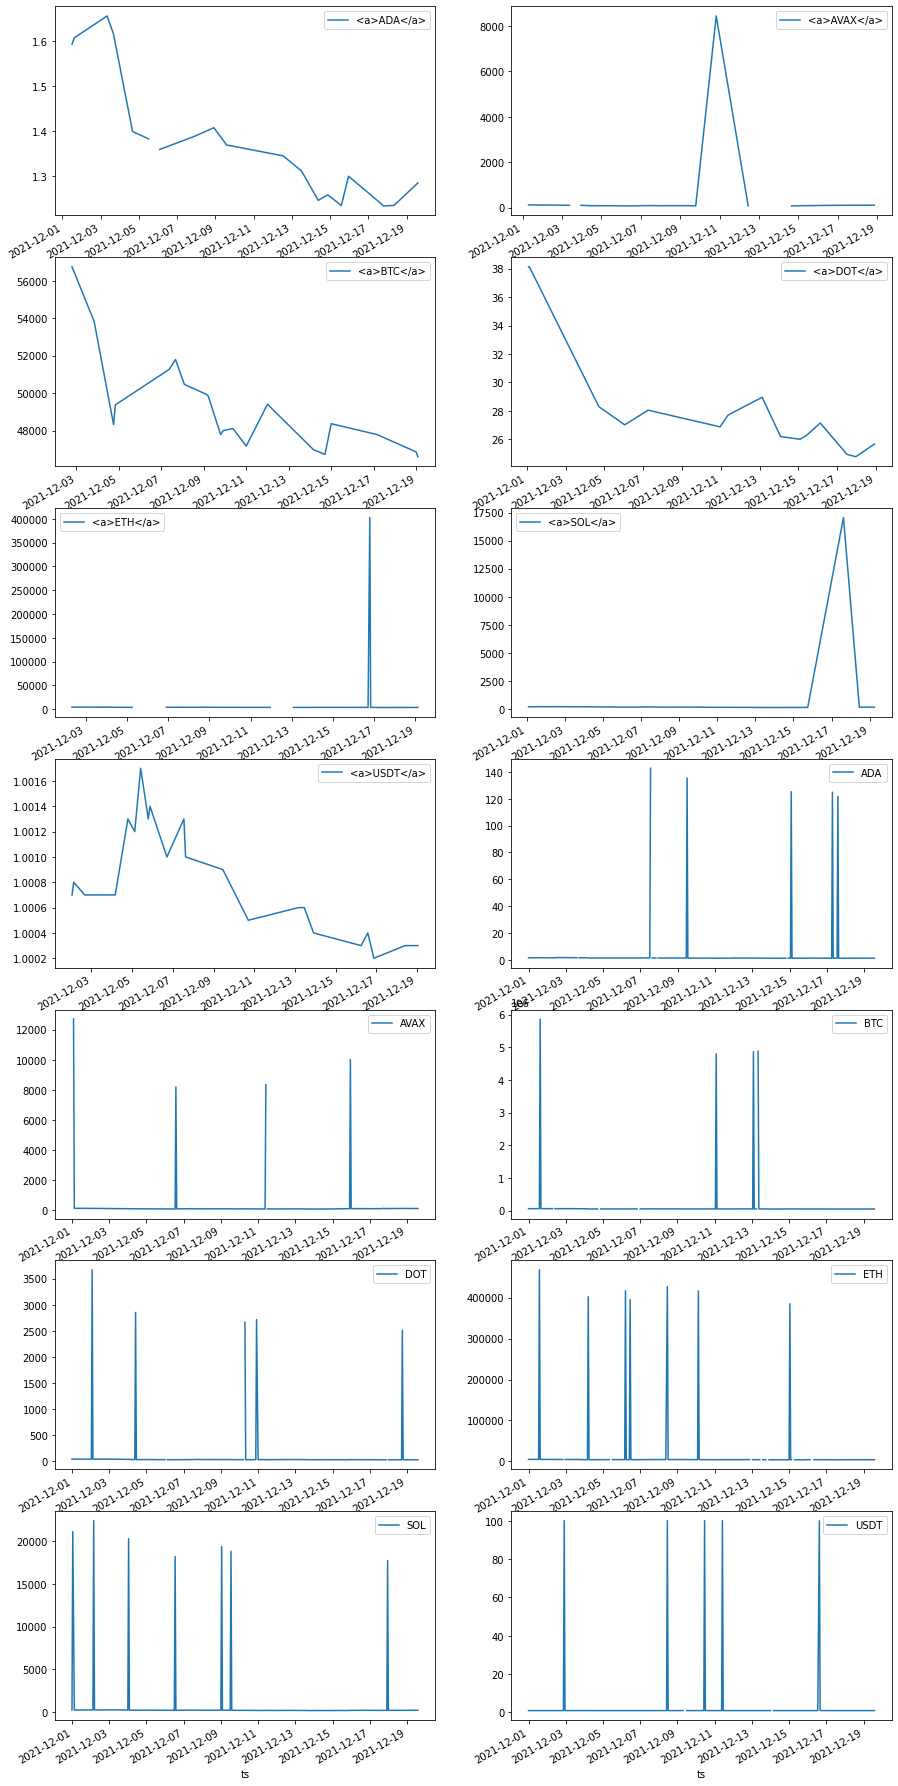

In [10]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1


we definitely see some missing data from this plot, but also we definitely have some outliers in our data

okay so what do we do?  let's get a plan of attack:
1. Let's remove the duplicated rows
2. Let's format the names for the tokens so we don't have the ones with tags
3. Let's use a heuristic for missing close price as average of high + low of they day

After this, we can take a look at our chart and see how we want to deal with the outliers


1. drop duplicates

In [11]:
df = df.drop_duplicates()

2. let's format the token names

In [14]:
df.loc[df['token'].str.contains('<a>'), 'token'] = df.loc[df['token'].str.contains('<a>'), 'token'].str.extract('<a>(.|\n)*?<\/a>')


In [12]:
df.loc[df['token'].str.contains('<a>'), 'token'].str.extract('<a>(.|\n)*?<\/a>')


,0
ts,
2021-12-06 07:00:00,L
2021-12-07 06:00:00,T
2021-12-17 15:00:00,L
2021-12-04 19:00:00,T
2021-12-19 06:00:00,L
...,...
2021-12-09 05:00:00,C
2021-12-13 22:00:00,L
2021-12-09 19:00:00,C


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3129 entries, 2021-12-11 17:00:00 to 2021-12-05 08:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       3129 non-null   float64
 1   high       3129 non-null   float64
 2   low        3129 non-null   float64
 3   close      2980 non-null   float64
 4   volume     3129 non-null   float64
 5   volumeUSD  3129 non-null   float64
 6   token      2977 non-null   object 
 7   chain      3129 non-null   object 
dtypes: float64(6), object(2)
memory usage: 220.0+ KB


3. use the heuristic for missing close prices as verage of high + low of the day

In [14]:
df.loc[df['close'].isnull(), 'close'] = 0.5 * (df.loc[df['close'].isnull(), 'high'] + df.loc[df['close'].isnull(), 'low'])

Let's plot the same chart again

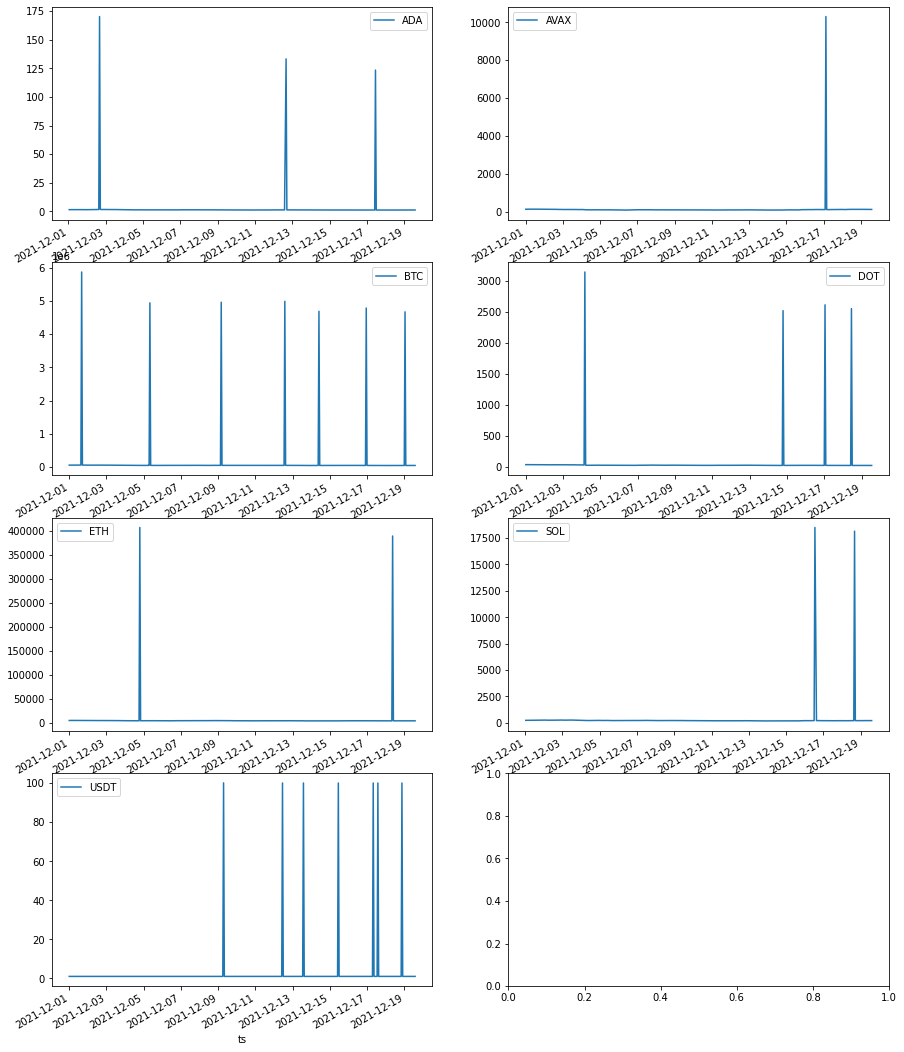

In [15]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1


So we now have good names, no duplicates and no missing values as we can see from the chart, however we still have these massive outliers.  Let's see how to deal with these.

Let's come up with a heuristic to define an outlier, as something where the close price is greater than 2x higher or lower than the open price (given this is hourly data, we shouldn't expect it to change that much)

In [16]:
df.loc[df.close / df.open >= 2]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-17 01:00:00,26.0200,26.1900,25.8900,2611.00,1.030910e+05,2.688727e+06,DOT,DOT
2021-12-12 14:00:00,49542.3900,49925.6200,49534.7100,4983812.00,3.426704e+02,1.703714e+07,BTC,BTC
2021-12-04 04:00:00,32.9240,32.9310,31.4000,3140.00,1.590922e+05,5.116880e+06,DOT,DOT
2021-12-17 11:00:00,1.2485,1.2487,1.2286,123.38,1.753446e+06,2.167650e+06,ADA,ADA
2021-12-09 04:00:00,49935.3800,49981.5900,49487.7400,4956525.00,5.137413e+02,2.556910e+07,BTC,BTC
2021-12-14 10:00:00,47483.7000,47516.7500,46819.3600,4684785.00,3.205093e+02,1.511988e+07,BTC,BTC
2021-12-12 16:00:00,1.3409,1.3418,1.3271,133.17,1.343873e+06,1.794386e+06,ADA,ADA
2021-12-18 16:00:00,182.0200,183.6700,181.2800,18160.00,4.082680e+04,7.442983e+06,SOL,SOL
2021-12-18 09:00:00,3892.6900,3919.8200,3877.1100,389548.00,2.276238e+03,8.878755e+06,ETH,ETH


this heuristic looks okay - let's use the missing value heuristic to fill these in:

In [17]:
df.loc[df.close / df.open >= 2, 'close'] = 0.5 * (df.loc[df.close / df.open >= 2, 'high'] + df.loc[df.close / df.open >= 2, 'low'])


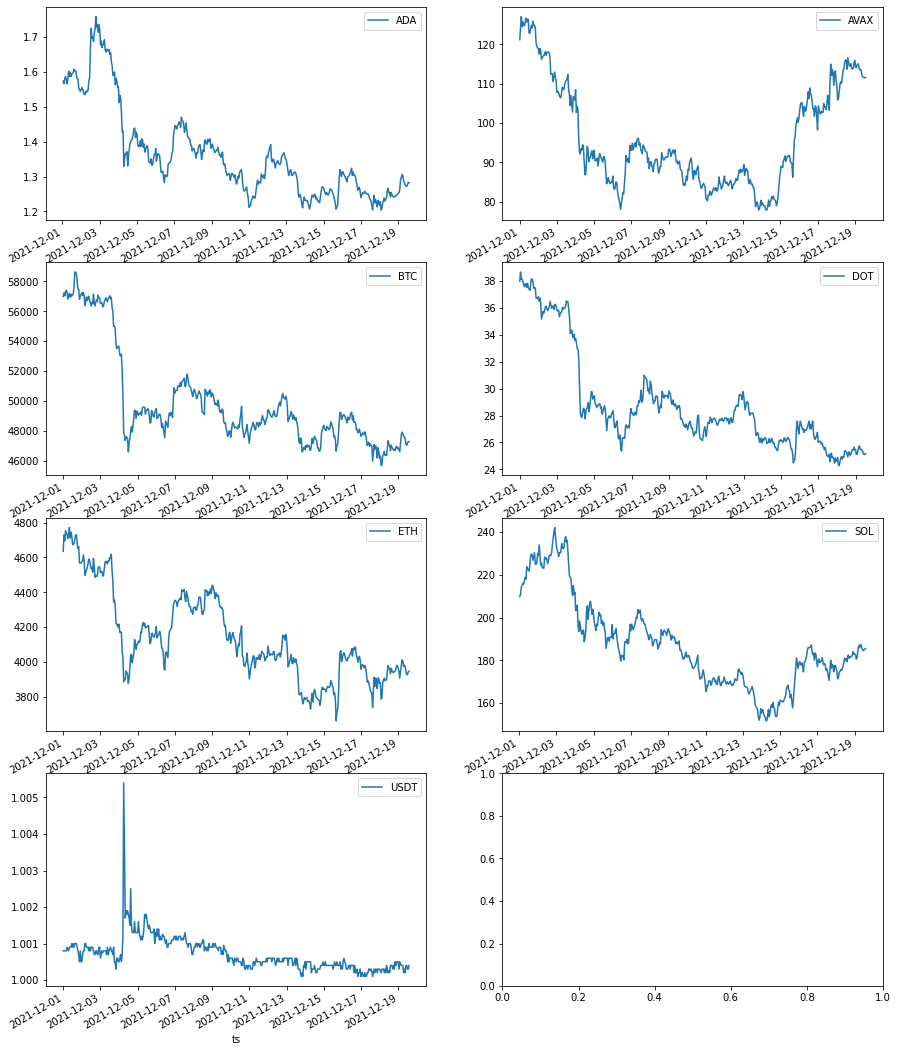

In [18]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'close']].groupby('token'):
    df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3129 entries, 2021-12-18 10:00:00 to 2021-12-09 05:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       3129 non-null   float64
 1   high       3129 non-null   float64
 2   low        3129 non-null   float64
 3   close      3129 non-null   float64
 4   volume     3129 non-null   float64
 5   volumeUSD  3129 non-null   float64
 6   token      2973 non-null   object 
 7   chain      3129 non-null   object 
dtypes: float64(6), object(2)
memory usage: 220.0+ KB
